In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, '% of Samples')

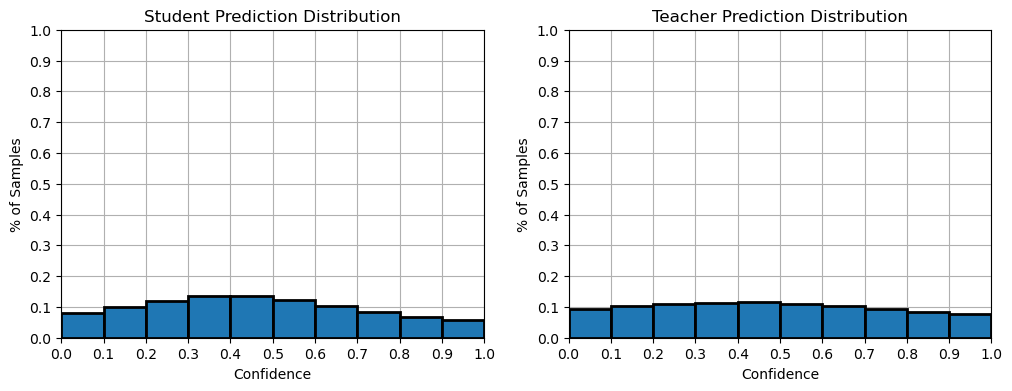

In [545]:
# generate the bin template
n_bins = 10
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
total_preds = 100000

def normal_density(mu,sigma,x):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-np.square(x-mu)/(2*sigma**2))

# define how the predictions are distributed across bins
# b = np.random.dirichlet(np.ones(n_bins)*10,size=1)[0]
b_S = torch.nn.functional.softmax(torch.tensor(normal_density(0.4,0.35,np.linspace(0,1,10))),dim=0)#np.ones(n_bins)/n_bins
b_T = torch.nn.functional.softmax(torch.tensor(normal_density(0.4,0.5,np.linspace(0,1,10))),dim=0)#np.random.dirichlet(np.ones(n_bins)*10,size=1)[0]
bars = np.arange(0,1+1*bin_uppers[0],1/n_bins)
bars = [str(round(bar,2)) for bar in bars]
xpos = np.arange(0,n_bins+1)
xtickpos = [xpos[i]-0.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].bar(xpos[:-1],b_S,width=1,edgecolor='black',linewidth=2)
ax[0].set_xticks(xtickpos,bars)
ax[0].set_ylim([0,1])
ax[0].set_xlim(-0.5,n_bins-0.5)
ax[0].grid()
ax[0].set_title("Student Prediction Distribution")
ax[0].set_xlabel("Confidence")
ax[0].set_ylabel("% of Samples")
ax[0].set_yticks(np.linspace(0,1,11))

ax[1].bar(xpos[:-1],b_T,width=1,edgecolor='black',linewidth=2)
ax[1].set_xticks(xtickpos,bars)
ax[1].set_ylim([0,1])
ax[1].set_xlim(-0.5,n_bins-0.5)
ax[1].grid()
ax[1].set_title("Teacher Prediction Distribution")
ax[1].set_xlabel("Confidence")
ax[1].set_yticks(np.linspace(0,1,11))
ax[1].set_ylabel("% of Samples")

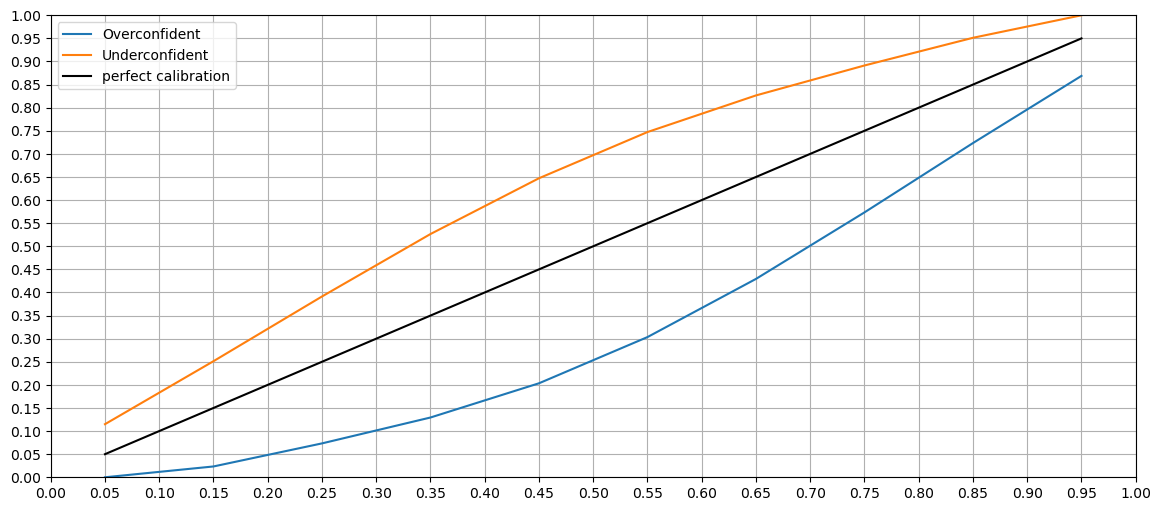

In [549]:
means = bin_uppers-bin_uppers[0]/2
# define confs as uniform within the bin
confs = torch.zeros((n_bins,int(total_preds/n_bins)))
for bin in range(n_bins):
    start = bin/n_bins
    end = (bin+1)/n_bins
    confs[bin,:] = (torch.rand(confs.shape[1]))*(end-start)+start

# define accuracy deviation using a normal distribution
mu = 0.5
sigma = 0.3
normal_weights = normal_density(mu,sigma,np.linspace(1/(2*n_bins),1-1/(2*n_bins),n_bins))
dev_factor = normal_density(mu,sigma,mu)
devs_o = normal_weights*(.25/dev_factor)
devs_u = normal_weights*(.2/dev_factor)

# define acc deviation from the mean confidence
accs_o = means - devs_o
accs_o = [1 if acc > 1 else acc for acc in accs_o]
accs_o = [0 if acc < 0 else acc for acc in accs_o]
accs_u = means + devs_u
accs_u = [1 if acc > 1 else acc for acc in accs_u]
accs_u = [0 if acc < 0 else acc for acc in accs_u]
plt.figure(figsize=(14, 6), dpi=100)
plt.plot(np.linspace(1/(2*n_bins),1-1/(2*n_bins),n_bins),accs_o,label="Overconfident")
plt.plot(np.linspace(1/(2*n_bins),1-1/(2*n_bins),n_bins),accs_u,label="Underconfident")
accs = np.linspace(0.05,0.95,n_bins+1)
plt.plot(accs,accs,label="perfect calibration",color="black")
plt.yticks(np.linspace(0,1,21))
plt.xticks(np.linspace(0,1,21))
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()

In [589]:
conf_policies = np.linspace(0,1,11) # to increase granularity, we need more bins

exp_accs = []
exp_costs = []
accs_S = np.array(accs_o)
accs_T = np.array(accs_u)
pred_dist_S = np.array(b_S)
pred_dist_T = np.array(b_T)
avg_S_acc = sum(pred_dist_S*accs_S)
avg_T_acc = sum(pred_dist_T*accs_T)
for i,p in enumerate(conf_policies):
                    # accuracy contrib from student                               # accuracy contrib from teacher
    exp_accs.append(sum(accs_S[means > p]*pred_dist_S[means > p]) + sum(pred_dist_S[means <= p])*avg_T_acc)
    exp_costs.append(sum(pred_dist_S[means > p])*1 + sum(pred_dist_S[means <= p])*(10+1))

In [578]:
accs_S

array([0.        , 0.0234161 , 0.07333793, 0.12937577, 0.20344821,
       0.30344823, 0.42937575, 0.57333793, 0.72341606, 0.86883687])

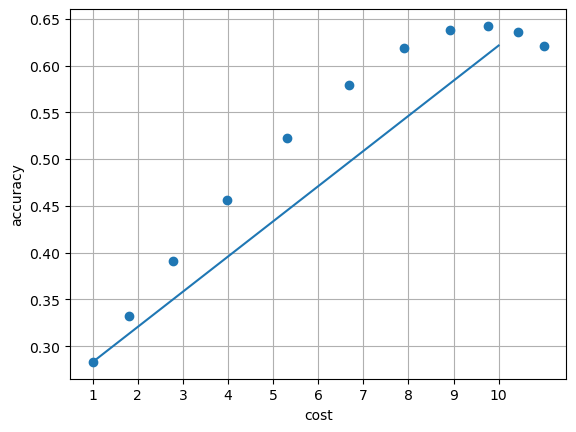

In [591]:
cost_T = 10
cost_S = 1
x = np.linspace(0,1,100)
cost = x*cost_S + (1-x)*cost_T
accuracy = x*avg_S_acc + (1-x)*avg_T_acc
plt.plot(cost,accuracy)
plt.xticks(np.arange(0,11))
plt.grid()
plt.xlabel("cost")
plt.ylabel("accuracy")
plt.scatter(exp_costs,exp_accs)


Interactive Mode

In [50]:
%matplotlib widget
# %matplotlib inline

0

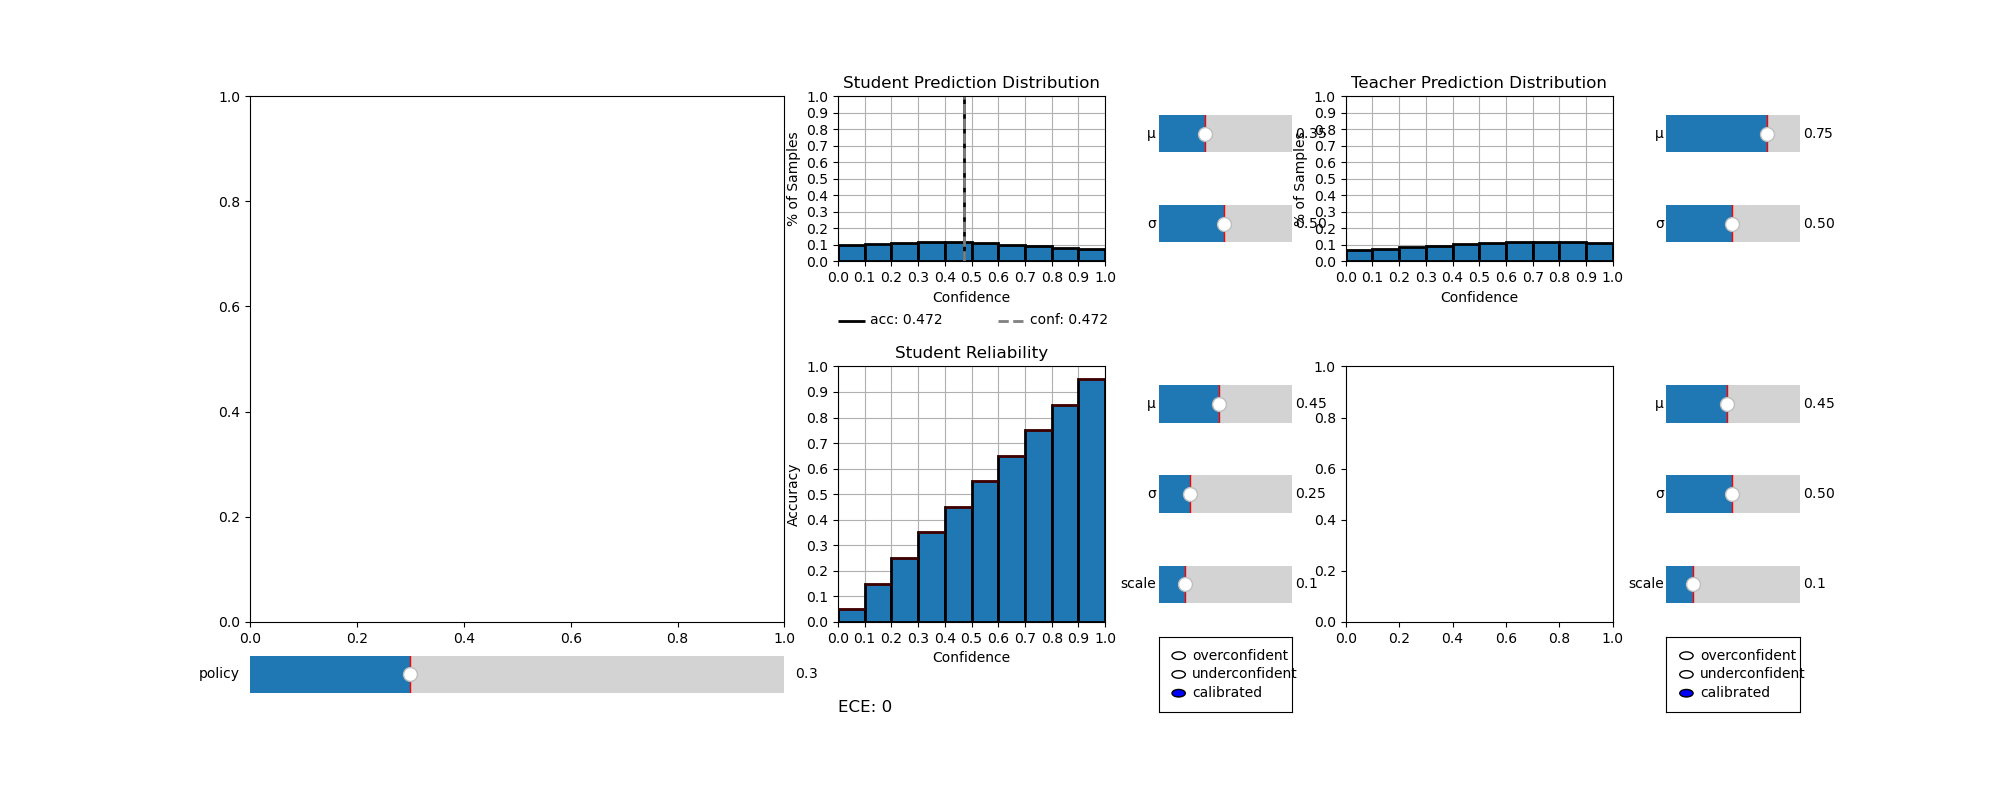

In [52]:
from matplotlib.widgets import Slider, Button, RadioButtons
plt.rc('axes', axisbelow=True)
# initialize figure layout
fig, axs = plt.subplot_mosaic([['tradeoff_plot','stud_dist','stud_dist_mu','teach_dist','teach_dist_mu'],
                               ['tradeoff_plot','stud_dist','stud_dist_sigma','teach_dist','teach_dist_sigma'],
                               ['tradeoff_plot','stud_avg_acc','stud_avg_conf','teach_avg_acc','teach_avg_conf'],
                               ['tradeoff_plot','stud_rel','stud_rel_mu','teach_rel','teach_rel_mu'],
                               ['tradeoff_plot','stud_rel','stud_rel_sigma','teach_rel','teach_rel_sigma'],
                               ['tradeoff_plot','stud_rel','stud_rel_scale','teach_rel','teach_rel_scale'],
                               ['tradeoff_slider','stud_ECE','stud_ou','teach_ECE','teach_ou']],figsize=(20, 8),
                               gridspec_kw={'width_ratios': [1,0.5,0.25,0.5,0.25],'height_ratios': [0.5,0.5,0.5,0.5,0.5,0.5,0.5]})

# initialize widgets
stud_dist_mu = Slider(axs['stud_dist_mu'], 'μ', 0, 1.0, valinit=0.35,orientation="horizontal")
teach_dist_mu = Slider(axs['teach_dist_mu'], 'μ', 0, 1.0, valinit=0.75,orientation="horizontal")
stud_dist_sigma = Slider(axs['stud_dist_sigma'], 'σ', 0.02, 1.0, valinit=0.5,orientation="horizontal")
teach_dist_sigma = Slider(axs['teach_dist_sigma'], 'σ', 0.02, 1.0, valinit=0.5,orientation="horizontal")

stud_rel_mu = Slider(axs['stud_rel_mu'], 'μ', 0, 1.0, valinit=0.45,orientation="horizontal")
teach_rel_mu = Slider(axs['teach_rel_mu'], 'μ', 0, 1.0, valinit=0.45,orientation="horizontal")
stud_rel_sigma = Slider(axs['stud_rel_sigma'], 'σ', 0.02, 1.0, valinit=0.25,orientation="horizontal")
teach_rel_sigma = Slider(axs['teach_rel_sigma'], 'σ', 0.02, 1.0, valinit=0.5,orientation="horizontal")
stud_rel_scale = Slider(axs['stud_rel_scale'], 'scale', 0, 0.5, valinit=0.1,orientation="horizontal")
teach_rel_scale = Slider(axs['teach_rel_scale'], 'scale', 0, 0.5, valinit=0.1,orientation="horizontal")

policy = Slider(axs['tradeoff_slider'], 'policy', 0, 1.0, valinit=0.3,valstep=0.1,orientation="horizontal")

stud_ou = RadioButtons(axs['stud_ou'],('overconfident','underconfident','calibrated'),active=2)
teach_ou = RadioButtons(axs['teach_ou'],('overconfident','underconfident','calibrated'),active=2)

axs['stud_avg_acc'].axis('off')
axs['stud_avg_conf'].axis('off')
axs['teach_avg_acc'].axis('off')
axs['teach_avg_conf'].axis('off')
axs['stud_ECE'].axis('off')
axs['teach_ECE'].axis('off')

# set up global variables
n_bins = 10
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
cal_bin_accs = bin_uppers-bin_uppers[0]/2

def normal_density(mu,sigma,x):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-np.square(x-mu)/(2*sigma**2))

bar_ticks = np.arange(0,1+1*bin_uppers[0],1/n_bins)
bar_ticks = [str(round(bar,2)) for bar in bar_ticks]
bar_xpos = np.arange(0,n_bins+1)
bar_xtickpos = [bar_xpos[i]-0.5 for i in range(len(bar_xpos))]


# init stud dist
b_S = torch.nn.functional.softmax(torch.tensor(normal_density(stud_dist_mu.val,stud_dist_sigma.val,np.linspace(0,1,n_bins))),dim=0)
stud_dist_bars = axs['stud_dist'].bar(bar_xpos[:-1],b_S,width=1,edgecolor='black',linewidth=2)
axs['stud_dist'].set_xticks(bar_xtickpos,bar_ticks)
axs['stud_dist'].set_ylim([0,1])
axs['stud_dist'].set_xlim(-0.5,n_bins-0.5)
axs['stud_dist'].grid()
axs['stud_dist'].set_title("Student Prediction Distribution")
axs['stud_dist'].set_xlabel("Confidence")
axs['stud_dist'].set_ylabel("% of Samples")
axs['stud_dist'].set_yticks(np.linspace(0,1,11))

def stud_dist_update(val):
    # get the new distribution bins
    b_S = torch.nn.functional.softmax(torch.tensor(normal_density(stud_dist_mu.val,stud_dist_sigma.val,np.linspace(0,1,n_bins))),dim=0)
    for i,b in enumerate(stud_dist_bars):
        b_S[i] = 1 if (b_S[i] > 1) else b_S[i]
        b.set_height(b_S[i])
    stud_rel_update(1)

stud_dist_mu.on_changed(stud_dist_update)
stud_dist_sigma.on_changed(stud_dist_update)


# init teach dist
b_T = torch.nn.functional.softmax(torch.tensor(normal_density(teach_dist_mu.val,teach_dist_sigma.val,np.linspace(0,1,n_bins))),dim=0)
teach_dist_bars = axs['teach_dist'].bar(bar_xpos[:-1],b_T,width=1,edgecolor='black',linewidth=2)
axs['teach_dist'].set_xticks(bar_xtickpos,bar_ticks)
axs['teach_dist'].set_ylim([0,1])
axs['teach_dist'].set_xlim(-0.5,n_bins-0.5)
axs['teach_dist'].grid()
axs['teach_dist'].set_title("Teacher Prediction Distribution")
axs['teach_dist'].set_xlabel("Confidence")
axs['teach_dist'].set_ylabel("% of Samples")
axs['teach_dist'].set_yticks(np.linspace(0,1,11))

def teach_dist_update(val):
    # get the new distribution bins
    b_T = torch.nn.functional.softmax(torch.tensor(normal_density(teach_dist_mu.val,teach_dist_sigma.val,np.linspace(0,1,n_bins))),dim=0)
    for i,b in enumerate(teach_dist_bars):
        b_T[i] = 1 if (b_T[i] > 1) else b_T[i]
        b.set_height(b_T[i])

teach_dist_mu.on_changed(teach_dist_update)
teach_dist_sigma.on_changed(teach_dist_update)

# init stud rel
stud_rel_bars = axs['stud_rel'].bar(bar_xpos[:-1],cal_bin_accs,width=1,edgecolor='black',linewidth=2,label="acc")
stud_rel_gap = axs['stud_rel'].bar(bar_xpos[:-1],0,label="gap",width=1,edgecolor='red',bottom=cal_bin_accs,color='red',alpha=0.25,linewidth=2)
axs['stud_rel'].set_xticks(bar_xtickpos,bar_ticks)
axs['stud_rel'].set_ylim([0,1])
axs['stud_rel'].set_xlim(-0.5,n_bins-0.5)
axs['stud_rel'].grid()
axs['stud_rel'].set_title("Student Reliability")
axs['stud_rel'].set_xlabel("Confidence")
axs['stud_rel'].set_yticks(np.linspace(0,1,11))
axs['stud_rel'].set_ylabel("Accuracy")

stud_ece = axs['stud_ECE'].text(0,0,"ECE: "+str(0),fontsize="large")
stud_avg_acc_line = axs['stud_dist'].axvline(sum([b.get_height()*a.get_height() for b,a in zip(stud_dist_bars,stud_rel_bars)])*10-0.5,color="black",linestyle="-",linewidth=2)
stud_avg_conf_line = axs['stud_dist'].axvline(sum([b.get_height()*c for b,c in zip(stud_dist_bars,cal_bin_accs)])*10-0.5,color="gray",linestyle="--",linewidth=2)

axs['stud_avg_acc'].set_xlim([0,0.5])
axs['stud_avg_acc'].set_ylim([-0.25,0.25])
axs['stud_avg_acc'].hlines(y=-0.05,xmin=0.0,xmax=0.05,color="black",linewidth=2)
axs['stud_avg_acc'].hlines(y=-0.05,xmin=0.3,xmax=0.35,color="gray",linewidth=2,linestyle="--")
stud_avg_acc_text = axs['stud_avg_acc'].text(0.06,-0.07,"acc: "+str(round(sum([b.get_height()*a.get_height() for b,a in zip(stud_dist_bars,stud_rel_bars)]),3)))
stud_avg_conf_text = axs['stud_avg_acc'].text(0.36,-0.07,"conf: "+str(round(sum([b.get_height()*c for b,c in zip(stud_dist_bars,cal_bin_accs)]).item(),3)))

def stud_rel_update(val):
    # get the new deviations from perfect calibration
    normal_weights = normal_density(stud_rel_mu.val,stud_rel_sigma.val,np.linspace(1/(2*n_bins),1-1/(2*n_bins),n_bins))
    dev_factor = normal_density(stud_rel_mu.val,stud_rel_sigma.val,stud_rel_mu.val) # peak of gaussian
    devs = normal_weights*(stud_rel_scale.val/dev_factor) # scale the devs up or down
    # print(devs)
    ece = 0
    for i,b in enumerate(stud_rel_bars):
        if stud_ou.value_selected == "overconfident":
            # bar_val = 1 if ((cal_bin_accs[i]-devs[i]) > 1) else cal_bin_accs[i]-devs[i]
            bar_val = 0 if ((cal_bin_accs[i]-devs[i]) < 0) else cal_bin_accs[i]-devs[i]
            b.set_height(bar_val)
            stud_rel_gap[i].set(y=bar_val,height=cal_bin_accs[i]-bar_val)
            # print(bar_val)
            ece += (stud_dist_bars[i].get_height()*abs(bar_val-cal_bin_accs[i])).item()
        elif stud_ou.value_selected == "underconfident":
            bar_val = 1 if ((cal_bin_accs[i]+devs[i]) > 1) else cal_bin_accs[i]+devs[i]
            # bar_val = 0 if ((cal_bin_accs[i]+devs[i]) < 0) else cal_bin_accs[i]+devs[i]
            b.set_height(bar_val)
            stud_rel_gap[i].set(y=bar_val-devs[i],height=devs[i])
            ece += (stud_dist_bars[i].get_height()*abs(bar_val-cal_bin_accs[i])).item()
        elif stud_ou.value_selected == "calibrated":
            b.set_height(cal_bin_accs[i])
            stud_rel_gap[i].set(y=cal_bin_accs[i],height=0)
    # update ece value 
    stud_ece.set(text="ECE: "+str(round(ece,4)))

    # update avg acc and avg conf
    acc = sum([b.get_height()*a.get_height() for b,a in zip(stud_dist_bars,stud_rel_bars)]).item()
    conf = sum([b.get_height()*c for b,c in zip(stud_dist_bars,cal_bin_accs)]).item()
    stud_avg_acc_line.set(xdata=acc*10-0.5)
    stud_avg_acc_text.set(text="acc: "+str(round(acc,3)))
    stud_avg_conf_line.set(xdata=conf*10-0.5)
    stud_avg_conf_text.set(text="conf: "+str(round(conf,3)))

stud_ou.on_clicked(stud_rel_update)
stud_rel_mu.on_changed(stud_rel_update)
stud_rel_sigma.on_changed(stud_rel_update)
stud_rel_scale.on_changed(stud_rel_update)